In [1]:
import pandas as pd
from PIL import Image
import io
import json
import matplotlib.pyplot as plt
import re
import tensorflow as tf

In [2]:
parquet_file = [
    'data/train-00000-of-00004-b4aaeceff1d90ecb.parquet',
    'data/train-00001-of-00004-7dbbe248962764c5.parquet',
    'data/train-00002-of-00004-688fe1305a55e5cc.parquet',
    'data/train-00003-of-00004-2d0cd200555ed7fd.parquet'
    ]

df = pd.concat([pd.read_parquet(f) for f in parquet_file], ignore_index=True)

In [3]:
len(df)

800

In [4]:
df.head()

image  \
0  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
2  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
3  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
4  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   

                                        ground_truth  
0  {"gt_parse": {"menu": [{"nm": "Nasi Campur Bal...  
1  {"gt_parse": {"menu": [{"nm": "SPGTHY BOLOGNAS...  
2  {"gt_parse": {"menu": [{"nm": "HAKAU UDANG", "...  
3  {"gt_parse": {"menu": [{"nm": "Bintang Bremer"...  
4  {"gt_parse": {"menu": {"nm": "BASO BIHUN", "un...

In [5]:
df['ground_truth']

0      {"gt_parse": {"menu": [{"nm": "Nasi Campur Bal...
1      {"gt_parse": {"menu": [{"nm": "SPGTHY BOLOGNAS...
2      {"gt_parse": {"menu": [{"nm": "HAKAU UDANG", "...
3      {"gt_parse": {"menu": [{"nm": "Bintang Bremer"...
4      {"gt_parse": {"menu": {"nm": "BASO BIHUN", "un...
                             ...                        
795    {"gt_parse": {"menu": {"nm": "DIHUN CAMPUR", "...
796    {"gt_parse": {"menu": [{"nm": "1066-Choconut B...
797    {"gt_parse": {"menu": [{"nm": "GRILLED BABY PO...
798    {"gt_parse": {"menu": {"nm": "Lemon Tea (L).",...
799    {"gt_parse": {"menu": {"nm": "Es Kopi Rupa", "...
Name: ground_truth, Length: 800, dtype: object

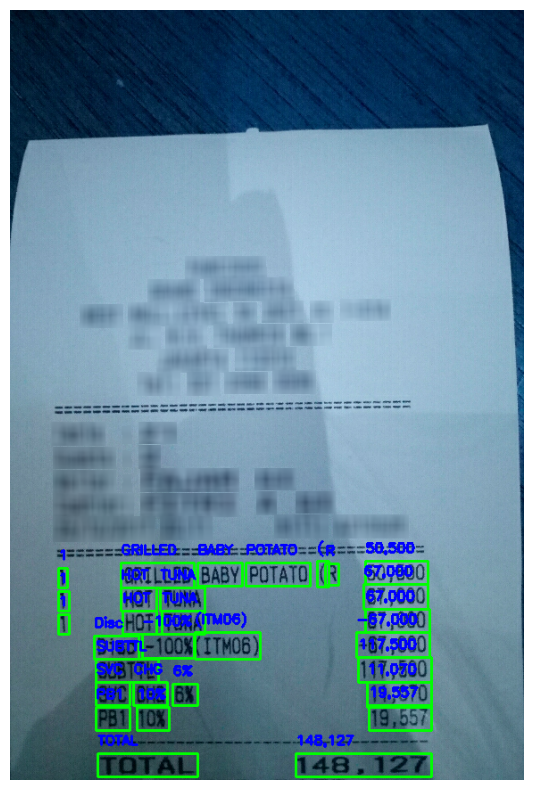

In [6]:
import json
import io
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

def display_image_with_labels(image_data, label_data, box_color=(0, 255, 0), text_color=(255, 0, 0), thickness=2, font_scale=0.5):
    """
    Menampilkan gambar dengan bounding box dan label teks menggunakan Matplotlib.
    
    Parameters:
    - image_data (dict): Data gambar dalam format bytes.
    - label_data (dict): Data label dalam format dictionary, berisi koordinat bounding box dan teks.
    - box_color (tuple): Warna bounding box (BGR).
    - text_color (tuple): Warna teks (BGR).
    - thickness (int): Ketebalan garis bounding box.
    - font_scale (float): Skala ukuran font untuk teks label.
    """
    
    # Load image and convert to OpenCV format
    image = image_data
    # image = Image.open(io.BytesIO(image_data['bytes']))
    # image = np.array(image)  # Convert PIL image to NumPy array
    
    # Set font for text
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    # Parse valid_line dan buat bounding box
    for line in label_data:
        for word in line['words']:
            quad = word['quad']
            
            # Define bounding box from the quad
            top_left = (quad['x1'], quad['y1'])
            bottom_right = (quad['x3'], quad['y3'])
            
            # Draw bounding box
            cv2.rectangle(image, top_left, bottom_right, box_color, thickness)
            
            # Write text label near the box
            text = word['text']
            cv2.putText(image, text, (quad['x1'], quad['y1'] - 10), font, font_scale, text_color, thickness)
    
    # Convert BGR to RGB for displaying in matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display the image with bounding boxes using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes for a cleaner look
    plt.show()

# Contoh penggunaan
index = 797
ground_truth = json.loads(df.iloc[index]['ground_truth'])  # Parse JSON string to a Python dict
image_data = df.iloc[index]['image']
image = Image.open(io.BytesIO(image_data['bytes']))
image_data = np.array(image)  
display_image_with_labels(image_data, ground_truth['valid_line'])


In [7]:
# Fungsi untuk melakukan preprocessing dan menghapus objek tertentu pada JSON
def preprocess_json(json_data, keys_to_remove=None, keys_to_remove_2=None):
    if keys_to_remove is None:
        keys_to_remove = ["category", "group_id", "sub_group_id"]  # Tentukan key yang ingin dihapus
    if keys_to_remove_2 is None:
        keys_to_remove_2 = ["is_key", "row_id"]  # Tentukan key yang ingin dihapus
    
    # Parse JSON string menjadi dictionary
    parsed_json = json.loads(json_data)
    
    # Menghapus keys tertentu dalam "menu" untuk setiap item
    for item in parsed_json['valid_line']:
        for key in keys_to_remove:
            item.pop(key, None)  # Hapus key jika ada
        for quad in item['words']:
            for key_2 in keys_to_remove_2:
                quad.pop(key_2, None)  # Hapus key jika ada 

    # Mengembalikan JSON yang sudah dimodifikasi sebagai string
    return parsed_json['valid_line']

# Terapkan preprocessing ke setiap entri dalam kolom `ground_truth`
df['kotak'] = df['ground_truth'].apply(lambda x: preprocess_json(x))

# Tampilkan hasil
df['kotak'].head()


0    [{'words': [{'quad': {'x2': 244, 'y3': 390, 'x...
1    [{'words': [{'quad': {'x2': 74, 'y3': 512, 'x3...
2    [{'words': [{'quad': {'x2': 272, 'y3': 489, 'x...
3    [{'words': [{'quad': {'x2': 317, 'y3': 806, 'x...
4    [{'words': [{'quad': {'x2': 172, 'y3': 836, 'x...
Name: kotak, dtype: object

In [8]:
# Fungsi untuk melakukan preprocessing dan menghapus objek tertentu pada JSON
def preprocess_json_get_total(json_data, keys_to_remove=None, keys_to_remove_2=None):
    # Parse JSON string menjadi dictionary
    parsed_json = json.loads(json_data)
    
    parsed_json['gt_parse'].pop('menu', None)
    parsed_json['gt_parse'].pop('sub_total', None)
    total = parsed_json['gt_parse'].get('total', {})
    total_price = total.get('total_price', None)

    if isinstance(total_price, str):  # Pastikan hanya memproses jika total_price adalah string
        # Hapus semua karakter non-numerik kecuali angka
        cleaned_price = re.sub(r'[^0-9]', '', total_price)
        # Ubah menjadi float jika hasil pembersihan tidak kosong
        return float(cleaned_price) if cleaned_price else None
    elif isinstance(total_price, list):  # Jika total_price adalah list
        # Ambil elemen pertama jika ada, lalu bersihkan
        if len(total_price) > 0 and isinstance(total_price[0], str):
            cleaned_price = re.sub(r'[^0-9]', '', total_price[0])
            return float(cleaned_price) if cleaned_price else None
    return None
    # Mengembalikan JSON yang sudah dimodifikasi sebagai string
    # return total_price

# Terapkan preprocessing ke setiap entri dalam kolom `ground_truth`
df['total_harga'] = df['ground_truth'].apply(lambda x: preprocess_json_get_total(x))

# Tampilkan hasil
df['total_harga']


0      1591600.0
1       580965.0
2       334000.0
3       302016.0
4        48000.0
         ...    
795      48000.0
796      28000.0
797     148127.0
798      30000.0
799      18000.0
Name: total_harga, Length: 800, dtype: float64

In [9]:
df.iloc[111]['total_harga']

np.float64(72600.0)

In [10]:
df.iloc[0]['kotak']

[{'words': [{'quad': {'x2': 244,
     'y3': 390,
     'x3': 244,
     'y4': 390,
     'x1': 232,
     'y1': 372,
     'x4': 232,
     'y2': 372},
    'text': '1'},
   {'quad': {'x2': 270,
     'y3': 390,
     'x3': 270,
     'y4': 390,
     'x1': 256,
     'y1': 374,
     'x4': 256,
     'y2': 374},
    'text': 'x'}]},
 {'words': [{'quad': {'x2': 354,
     'y3': 390,
     'x3': 354,
     'y4': 390,
     'x1': 302,
     'y1': 368,
     'x4': 302,
     'y2': 368},
    'text': 'Nasi'},
   {'quad': {'x2': 440,
     'y3': 391,
     'x3': 439,
     'y4': 388,
     'x1': 364,
     'y1': 365,
     'x4': 363,
     'y2': 368},
    'text': 'Campur'},
   {'quad': {'x2': 497,
     'y3': 385,
     'x3': 499,
     'y4': 388,
     'x1': 446,
     'y1': 365,
     'x4': 448,
     'y2': 362},
    'text': 'Bali'}]},
 {'words': [{'quad': {'x2': 618,
     'y3': 388,
     'x3': 618,
     'y4': 388,
     'x1': 542,
     'y1': 362,
     'x4': 542,
     'y2': 362},
    'text': '75,000'}]},
 {'words': [{'quad': 

## Easy OCR

In [11]:
from shapely.geometry import Polygon

# Fungsi untuk menghitung Intersection over Union (IoU) dari dua bounding boxes
def calculate_iou(quad_gt, quad_pred):
    # Mengonversi koordinat quad menjadi Polygon Shapely
    poly_gt = Polygon([(quad_gt['x1'], quad_gt['y1']), (quad_gt['x2'], quad_gt['y2']), 
                       (quad_gt['x3'], quad_gt['y3']), (quad_gt['x4'], quad_gt['y4'])])
    poly_pred = Polygon([(quad_pred['x1'], quad_pred['y1']), (quad_pred['x2'], quad_pred['y2']),
                         (quad_pred['x3'], quad_pred['y3']), (quad_pred['x4'], quad_pred['y4'])])
    
    # Menghitung area intersection dan union
    intersection = poly_gt.intersection(poly_pred).area
    union = poly_gt.union(poly_pred).area
    iou = intersection / union if union != 0 else 0
    return iou

# Fungsi evaluasi precision, recall, dan IoU
def evaluate_ocr(dataset, predictions, iou_threshold=0.5):
    true_positive = 0
    false_positive = 0
    false_negative = 0
    iou_scores = []

    for item_gt in dataset:
        matched = False
        for item_pred in predictions:
            for word_gt in item_gt['words']:
                for word_pred in item_pred['words']:
                    # Memeriksa apakah teksnya cocok
                    if word_gt['text'].lower() == word_pred['text'].lower():
                        iou = calculate_iou(word_gt['quad'], word_pred['quad'])
                        iou_scores.append(iou)
                        
                        # Jika IoU memenuhi ambang batas, hitung sebagai true positive
                        if iou >= iou_threshold:
                            true_positive += 1
                            matched = True
                            break
                if matched:
                    break
        if not matched:
            # Jika tidak ada kecocokan, hitung sebagai false negative
            false_negative += 1

    # Hitung false positive
    for item_pred in predictions:
        matched = False
        for item_gt in dataset:
            for word_pred in item_pred['words']:
                for word_gt in item_gt['words']:
                    # Memeriksa apakah teksnya cocok
                    if word_pred['text'].lower() == word_gt['text'].lower():
                        iou = calculate_iou(word_gt['quad'], word_pred['quad'])
                        
                        if iou >= iou_threshold:
                            matched = True
                            break
                if matched:
                    break
        if not matched:
            # Jika prediksi tidak ada di ground truth, hitung sebagai false positive
            false_positive += 1

    # Menghitung Precision, Recall, dan F1-score
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) != 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    avg_iou = sum(iou_scores) / len(iou_scores) if iou_scores else 0

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "average_iou": avg_iou
    }

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Hasil evaluasi OCR: {'precision': 0.47368421052631576, 'recall': 0.375, 'f1_score': 0.4186046511627907, 'average_iou': 0.19503212820652518}


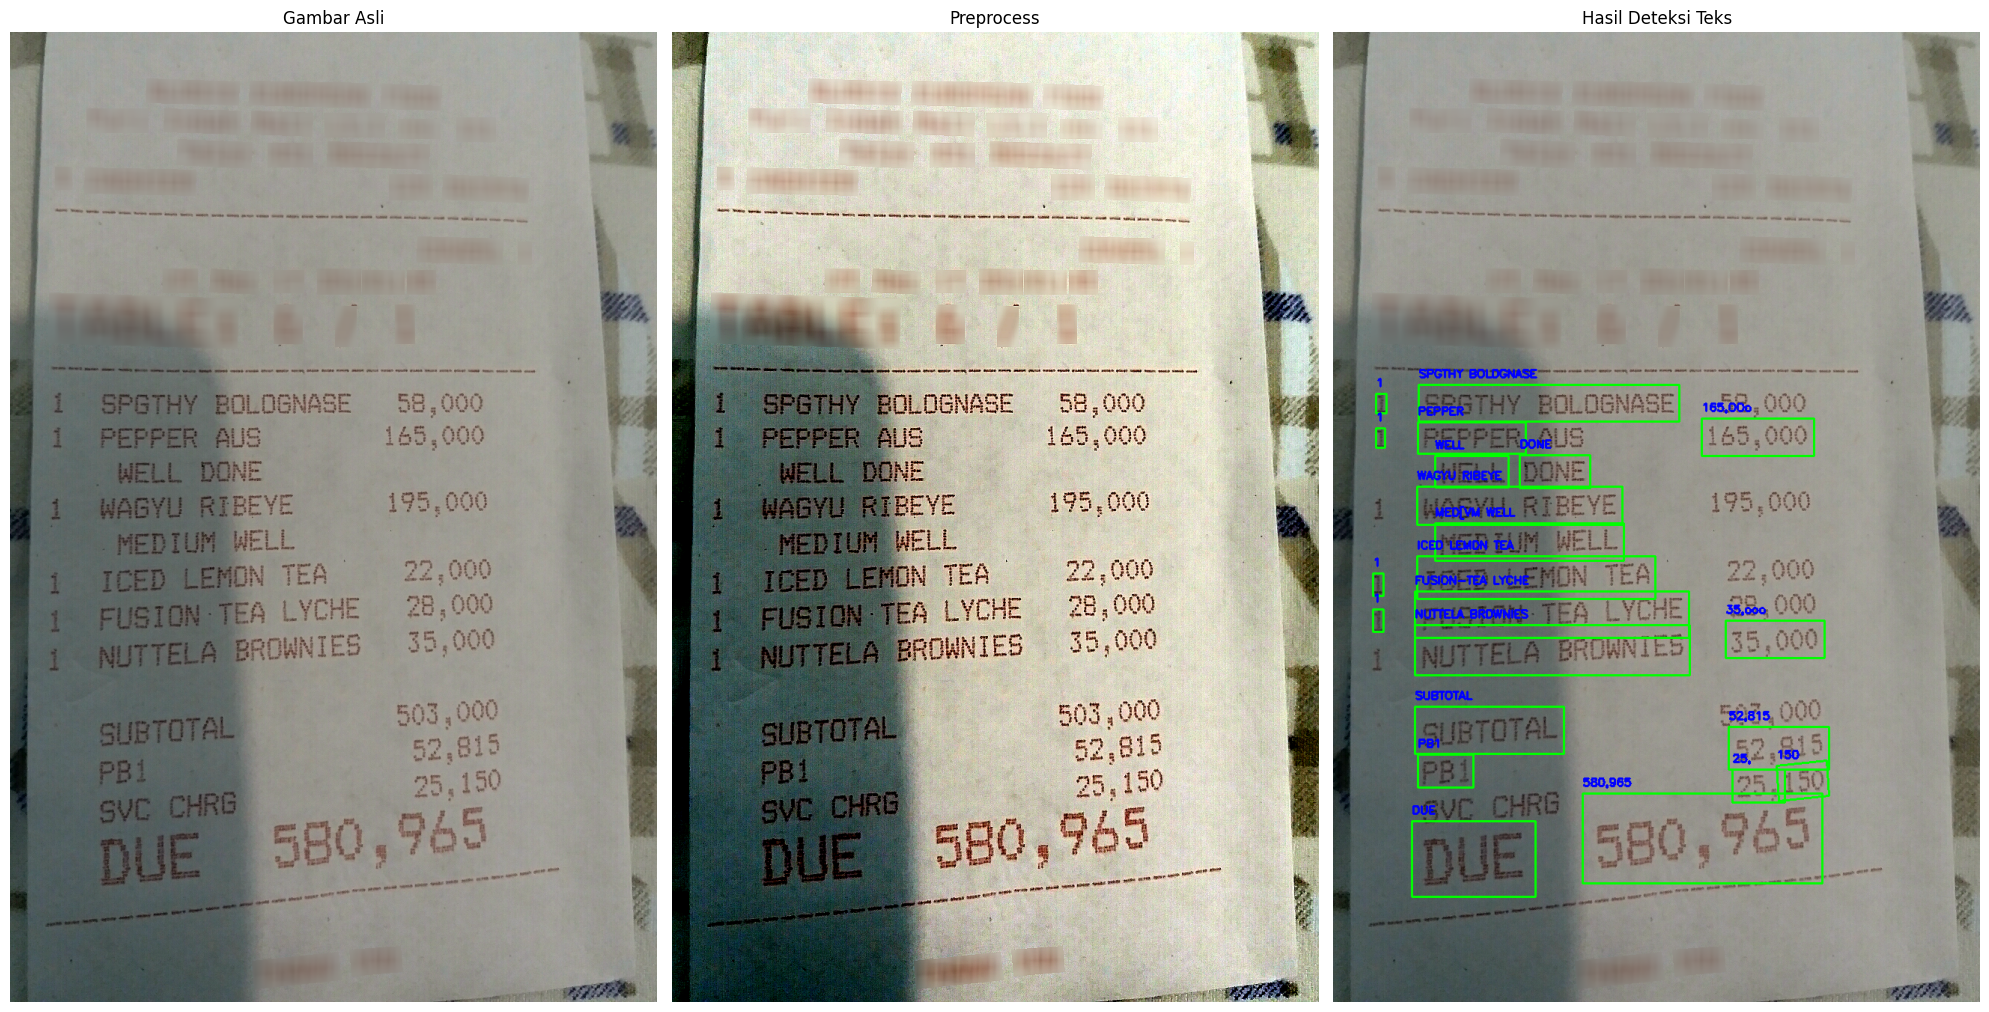

[{'words': [{'quad': {'x1': 57, 'y1': 483, 'x2': 71, 'y2': 483, 'x3': 71, 'y3': 509, 'x4': 57, 'y4': 509}, 'text': '1'}]}, {'words': [{'quad': {'x1': 114, 'y1': 471, 'x2': 462, 'y2': 471, 'x3': 462, 'y3': 520, 'x4': 114, 'y4': 520}, 'text': 'SPGTHY BOLDGNASE'}]}, {'words': [{'quad': {'x1': 57, 'y1': 529, 'x2': 69, 'y2': 529, 'x3': 69, 'y3': 555, 'x4': 57, 'y4': 555}, 'text': '1'}]}, {'words': [{'quad': {'x1': 113, 'y1': 521, 'x2': 257, 'y2': 521, 'x3': 257, 'y3': 563, 'x4': 113, 'y4': 563}, 'text': 'PEPPER'}]}, {'words': [{'quad': {'x1': 492, 'y1': 516, 'x2': 642, 'y2': 516, 'x3': 642, 'y3': 566, 'x4': 492, 'y4': 566}, 'text': '165,OOo'}]}, {'words': [{'quad': {'x1': 136, 'y1': 566, 'x2': 234, 'y2': 566, 'x3': 234, 'y3': 608, 'x4': 136, 'y4': 608}, 'text': 'WELL'}]}, {'words': [{'quad': {'x1': 249, 'y1': 565, 'x2': 343, 'y2': 565, 'x3': 343, 'y3': 609, 'x4': 249, 'y4': 609}, 'text': 'DONE'}]}, {'words': [{'quad': {'x1': 112, 'y1': 607, 'x2': 386, 'y2': 607, 'x3': 386, 'y3': 658, 'x4': 

In [12]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance
import json
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import imutils
from imutils.perspective import four_point_transform
import easyocr

class EasyReceiptOCR:
    def __init__(self, lang=['en']):
        # Initialize EasyOCR with specified languages
        self.reader = easyocr.Reader(lang)

    def preprocess_image2(self, image) -> np.ndarray:
        """
        Preprocessing menggunakan PIL.ImageEnhance:
        - Meningkatkan kontras
        - Menyesuaikan kecerahan
        - Menajamkan gambar
        """
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        # Konversi ke mode RGB (pastikan formatnya sesuai)
        image = image.convert('RGB')

        # Tingkatkan kontras
        enhancer_contrast = ImageEnhance.Contrast(image)
        image = enhancer_contrast.enhance(2.0)  # Tingkat kontras (sesuaikan nilainya)

        # Tingkatkan kecerahan
        enhancer_brightness = ImageEnhance.Brightness(image)
        image = enhancer_brightness.enhance(1.2)  # Tingkat kecerahan (sesuaikan nilainya)

        # Tingkatkan ketajaman
        enhancer_sharpness = ImageEnhance.Sharpness(image)
        image = enhancer_sharpness.enhance(2.5)  # Tingkat ketajaman (sesuaikan nilainya)

        # Konversi kembali ke format OpenCV (array NumPy) jika diperlukan
        image_np = np.array(image)
        return image_np

    def preprocess_image(self, image) -> np.ndarray:
        """
        Memproses gambar untuk meningkatkan akurasi OCR
        """
        # Baca gambar
        image = image

        # Konversi ke grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply adaptive thresholding
        binary = cv2.adaptiveThreshold(
            gray, 
            255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY, 
            21, 
            10
        )
        
        # Tingkatkan kontras menggunakan CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(binary)
        
        # Sharpening menggunakan unsharp masking
        gaussian_blur = cv2.GaussianBlur(enhanced, (0, 0), 3.0)
        sharpened = cv2.addWeighted(enhanced, 1.5, gaussian_blur, -0.5, 0)
        # Reduce noise
        denoised = cv2.fastNlMeansDenoising(sharpened)
        
        return denoised

    def extract_text_and_location(self, image) -> Tuple[List[Dict], np.ndarray]:
        """
        Mengekstrak teks dan lokasinya dari gambar struck menggunakan EasyOCR
        """
        
        # Proses gambar
        processed_image = self.preprocess_image2(image)
        
        # Buat salinan gambar untuk visualisasi
        visualization_image = image.copy()
        
        # Ekstrak data dengan EasyOCR
        receipt_data = []
        
        # Detect text using EasyOCR
        results = self.reader.readtext(processed_image)
        
        # Process each detected text
        for (bbox, text, prob) in results:
            if prob > 0.3:  # Filter low confidence detections
                # Get coordinates
                (top_left, top_right, bottom_right, bottom_left) = bbox
                x1, y1 = map(int, top_left)
                x2, y2 = map(int, top_right)
                x3, y3 = map(int, bottom_right)
                x4, y4 = map(int, bottom_left)
                
                # Draw rectangle and text on visualization image
                pts = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], np.int32)
                cv2.polylines(visualization_image, [pts], True, (0, 255, 0), 2)
                cv2.putText(visualization_image, text, 
                          (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                          0.5, (255, 0, 0), 2)
                
                # Create word data in required format
                word_data = {
                    "words": [{
                        "quad": {
                            "x1": x1,
                            "y1": y1,
                            "x2": x2,
                            "y2": y2,
                            "x3": x3,
                            "y3": y3,
                            "x4": x4,
                            "y4": y4
                        },
                        "text": text,
                    }],
                }
                receipt_data.append(word_data)
        
        return results, receipt_data, visualization_image

    def visualize_results(self, original_image: np.ndarray, visualization_image: np.ndarray):
        """
        Menampilkan hasil deteksi teks menggunakan matplotlib
        """
        plt.figure(figsize=(20, 10))
        
        # Tampilkan gambar asli
        plt.subplot(1, 3, 1)
        plt.title('Gambar Asli')
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')


        # Tampilkan bird's eye view
        plt.subplot(1, 3, 2)
        plt.title("Preprocess")
        plt.imshow(cv2.cvtColor(self.preprocess_image2(original_image), cv2.COLOR_BGR2RGB))
        plt.axis('off')
        
        
        # Tampilkan gambar dengan hasil deteksi
        plt.subplot(1, 3, 3)
        plt.title('Hasil Deteksi Teks')
        plt.imshow(cv2.cvtColor(visualization_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

    def save_to_json(self, data: List[Dict], output_path: str):
        """
        Menyimpan hasil ekstraksi ke file JSON
        """
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump({"valid_line": data}, f, indent=2, ensure_ascii=False)

    def extract_text_by_line(self, image) -> str:
        """
        Mengekstrak teks dari gambar, menggabungkan teks yang terdeteksi pada baris yang sama.
        """
        # Proses gambar
        processed_image = self.preprocess_image2(image)
        
        # Ekstrak teks menggunakan EasyOCR
        results = self.reader.readtext(processed_image)
        
        # Filter hasil dengan confidence > 0.3
        results = [(bbox, text) for bbox, text, prob in results if prob > 0.3]
        
        # Gabungkan teks berdasarkan posisi vertikal (y-coordinate)
        lines = []
        for bbox, text in results:
            # Koordinat y rata-rata (untuk baris)
            y_avg = sum([point[1] for point in bbox]) / 4
            added = False
            for line in lines:
                # Jika y_avg cukup dekat dengan baris yang ada, tambahkan ke baris itu
                if abs(line['y_avg'] - y_avg) < 10:  # Toleransi posisi vertikal
                    line['texts'].append(text)
                    added = True
                    break
            if not added:
                # Jika tidak ada baris yang cocok, buat baris baru
                lines.append({'y_avg': y_avg, 'texts': [text]})
        
        # Gabungkan teks dalam setiap baris, lalu gabungkan semua baris dengan enter
        extracted_text = "\n".join(["\t".join(line['texts']) for line in sorted(lines, key=lambda l: l['y_avg'])])
        
        return extracted_text


def main():
    # Contoh penggunaan
    ocr = EasyReceiptOCR(['en', 'id'])  # You can add more languages if needed, e.g. ['en', 'id']
    index = 1
    image_data = df.iloc[index]['image']
    image = Image.open(io.BytesIO(image_data['bytes']))
    image_data = np.array(image)
    
    # Ekstrak teks dan lokasi
    easy_results, receipt_data, visualization_image = ocr.extract_text_and_location(image_data)

    dataset_gt = df['kotak'].iloc[index]
    predictions = receipt_data

    # Evaluasi
    results = evaluate_ocr(dataset_gt, predictions)
    print("Hasil evaluasi OCR:", results)

    # Tampilkan hasil deteksi
    ocr.visualize_results(image_data, visualization_image)
    
    # Simpan hasil ke JSON
    # output_path = "receipt_output_easyocr.json"
    # ocr.save_to_json(receipt_data, output_path)

    print(receipt_data)

    print(easy_results)
    text = ocr.extract_text_by_line(image_data)
    print(text)

    # print(f"Hasil ekstraksi telah disimpan ke {output_path}")

if __name__ == "__main__":
    main()

In [13]:
import json
import pandas as pd
from tqdm import tqdm
from PIL import Image
import io
import numpy as np

ocr = EasyReceiptOCR(['en', 'id'])

# List untuk menyimpan hasil dari semua iterasi
all_easy_results = []
all_valid_line = []
all_text = []
all_total_harga = []

# Loop melalui setiap data dalam dataset dengan progress bar
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing images"):
    # Baca gambar dari dataset
    image_data = row['image']
    image = Image.open(io.BytesIO(image_data['bytes']))
    image_array = np.array(image)
    
    # Ekstrak teks dan lokasi
    easy_results, valid_line, _ = ocr.extract_text_and_location(image_array)
    text = ocr.extract_text_by_line(image_array)

    # Ambil nilai target `total_harga` dari dataframe
    total_harga = row['total_harga']

    # Tambahkan hasil ke dalam list
    all_easy_results.append({'easy_results': easy_results, 'total_harga': total_harga})
    all_valid_line.append({'valid_line': valid_line, 'total_harga': total_harga})
    all_text.append({'text': text, 'total_harga': total_harga})

# Simpan hasil ke dalam file JSON terpisah
with open("output/easy_results_with_label.json", "w") as easy_file:
    json.dump(all_easy_results, easy_file, ensure_ascii=False, indent=4)

with open("output/valid_line_with_label.json", "w") as valid_file:
    json.dump(all_valid_line, valid_file, ensure_ascii=False, indent=4)

with open("output/text_with_label.json", "w") as text_file:
    json.dump(all_text, text_file, ensure_ascii=False, indent=4)

print("Proses selesai! Semua data telah disimpan dalam file JSON terpisah.")


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Processing images:  17%|█▋        | 133/800 [30:18<2:31:58, 13.67s/it]


KeyboardInterrupt: 

In [ ]:
# # Inisialisasi objek OCR
# ocr = ocr = EasyReceiptOCR(['en', 'id']) 

# # List untuk menyimpan hasil evaluasi untuk setiap gambar
# evaluation_results = []

# # Loop melalui setiap data dalam dataset df
# for index, row in df.iterrows():
#     # Baca gambar dari dataset
#     image_data = row['image']
#     image = Image.open(io.BytesIO(image_data['bytes']))
#     image_array = np.array(image)
    
#     # Ekstrak teks dan lokasi
#     receipt_data, _ = ocr.extract_text_and_location(image_array)
    
#     # Ground truth untuk gambar ini
#     ground_truth = row['kotak']
    
#     # Evaluasi OCR untuk gambar ini
#     result = evaluate_ocr(ground_truth, receipt_data)
#     evaluation_results.append(result)
    
#     # Print hasil evaluasi untuk setiap gambar (opsional)
#     print(f"Hasil evaluasi OCR untuk gambar index {index}:", result)


In [ ]:
# # Menampilkan rata-rata hasil evaluasi dari seluruh gambar
# average_precision = sum([res['precision'] for res in evaluation_results]) / len(evaluation_results)
# average_recall = sum([res['recall'] for res in evaluation_results]) / len(evaluation_results)
# average_f1_score = sum([res['f1_score'] for res in evaluation_results]) / len(evaluation_results)
# average_iou = sum([res['average_iou'] for res in evaluation_results]) / len(evaluation_results)

# print("\nRata-rata hasil evaluasi OCR:")
# print("Precision:", average_precision)
# print("Recall:", average_recall)
# print("F1 Score:", average_f1_score)
# print("Average IoU:", average_iou)


In [ ]:
# import csv

# # Data output yang akan disimpan
# data = evaluation_results

# # Nama file CSV
# csv_file = 'output_metrics_easy.csv'

# # Menyimpan data ke CSV
# with open(csv_file, mode='w', newline='') as file:
#     writer = csv.DictWriter(file, fieldnames=data[0].keys())
    
#     # Tulis header
#     writer.writeheader()
    
#     # Tulis data
#     writer.writerows(data)

# print(f"Data berhasil disimpan ke {csv_file}")
